# Predictive Age Modeling for Abalones
## Introduction

Abalones are sea snails known for being seafood delicacies. The price of an abalone is positively correlated with its age. The standard method of determining an abalone's age is tedious and laborious. We aim to streamline this process using predictive modeling.

***Question:***
How does the number of rings an abalone has, and consequently its age, depend on its physical dimensions and weight?

In this project, we will be developing a model that predicts the age of an abalone using easily measurable physical traits. The data set we are using is from the UCI Machine Learning Repository. It contains comma-separated values with no headers and contains 4177 instances. It includes the ***sex, length (mm), diameter (mm), height (mm), whole weight (grams), shucked weight (grams, meat weight), viscera weight (grams, gut weight after bleeding), shell weight (grams, after drying), and number of rings*** of a given abalone. The range of the continuous variables has been pre-scaled by dividing by 200. Our target variable is the number of rings, which can then be used to calculate the age of an abalone in years by adding 1.5 to it.

## Methods and Results

#### Preparing the data

To prepare for analysis, the data was read into the program. The data was split into a training data set and a testing data set, with the training set being 75% of the actual data set. Summary statistics were produced for the training data. Basic visualizations were also generated to compare variables before the actual analysis was performed. These allow for a general overview of what the variables of this data set look like, how they are represented and described, and how they relate to each other. 

Diameter, height, and whole weight were our main predictors. This was to avoid any bias created by using four weight predictors and two length predictors. As seen in the graphs, there is an overlap of distributions and strong linear relations between similar variables. Sex will not be used as it is categorical instead of numerical.

The number of rings was our target variable. We decided not to create a new column for age due to the fact that we wanted to focus on variables that the data set provided for us. We later show how we find the age of hypothetical abalones given their diameters, heights, and whole weights. 

#### Performing the Analysis

Even though the number of rings is not a continuous value, since we will be predicting age (which is continuous), regression was the method of prediction that was used to analysis this data set. Approximate age can be found in years by adding 1.5 to the number of rings our model predicts. 

We decided to try predicting with K-nearest Neighbors regression and linear regression. We would then find their respective RMSPE (Root Mean Squared Prediction Error) values and compare to see which model had the lower value. It would also mean that model would make better predictions on data it was not trained with. 

The data was already split, so we continued with the analysis from there. Variables were set for the training set and the testing set to represent predictor variables (X_train and X_test) and the target variable (y_train and y_test). 

##### KNN Regression
A pipeline was created to chain together the StandardScaler() and the model object, which in this case is KNeighborsRegressor(). 
For the KNN regression, we perform a 5-fold cross-validation using GridSearchCV to choose the best k value. This would be the k value that results in the smallest RMSPE score. We then fit the data with the predictor variables and target variable to perform the tuning. The cv_results_ attribute contains cross-validation test scores for each choice of n_neighbors. The mean RMSPE values are then displayed with the the standard errors for each choice. The standard error shows how uncertain we are in the mean value. Using .best_params_, we find the best n_neighbors value, and a graph is plot to visualize this. The .best_score_ attribute is used to find the best RMSPE value associated with the best n_neighbors value. We are able to predict the number of rings for each observation in the testing set using the KNN regression fit. 
We find the RMSPE value and the RAE value for this model when it predicts on the testing set. 

##### Linear Regression
We fit the predictor variables and target variable with LinearRegression(). We are also able to find the intercept and the coefficients for each predictor variable. Since we are using three predictor variables, the equation we get describes the prediction space. We use the linear regression fit to predict the number of rings for each observation in the testing set. 
We then find the RMSPE value and the RAE value for this model when it predicts on the testing set. 

##### Predictions on new values
Finally, we create a new data frame that uses the model with the lower RMSPE value (which in this case was the KNN regression model) to predict a totally new observation with new predictor variables, outside of the testing set. 

##### Visualizations
3D and 2D plot visualizations were created to help visualize the predictions that the KNN regression model produced with the predictor variables. With the 3D plot, color was used in addition to three axes. For the 2D plot, each of the predictor variables were plotted using a scatter plot against the target variable to visualize trends. For the 2D visualizations, a predictions line was also overlaid on the graph that plots each of the predictor variables to the target variable. This shows how the model predictions fit into each one-on-one comparison. 

### Updating altair:

In [1]:
pip install -U altair

  Using cached altair-5.2.0-py3-none-any.whl (996 kB)
  Attempting uninstall: altair
    Found existing installation: altair 4.2.2
    Uninstalling altair-4.2.2:
      Successfully uninstalled altair-4.2.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipympl

  Using cached ipywidgets-8.1.1-py3-none-any.whl (139 kB)
  Using cached jupyterlab_widgets-3.0.9-py3-none-any.whl (214 kB)
  Using cached comm-0.2.0-py3-none-any.whl (7.0 kB)
  Using cached widgetsnbextension-4.0.9-py3-none-any.whl (2.3 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.4.2
    Uninstalling widgetsnbextension-3.4.2:
      Successfully uninstalled widgetsnbextension-3.4.2
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 1.1.4
    Uninstalling jupyterlab-widgets-1.1.4:
      Successfully uninstalled jupyterlab-widgets-1.1.4
  Attempting uninstall: comm
    Found existing installation: comm 0.1.2
    Uninstalling comm-0.1.2:
      Successfully uninstalled comm-0.1.2
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.4.2
    Uninstalling ipywidgets-7.4.2:
      Successfully uninstalled ipywidgets-7.4.2
ERROR: pip's dependency resolver does not curr

In [3]:
import pandas as pd
import altair as alt
import numpy as np
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simplify working with large datasets in Altair
alt.data_transformers.disable_max_rows()

# Output dataframes instead of arrays
set_config(transform_output="pandas")

from sklearn.model_selection import GridSearchCV, train_test_split
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Reading data from web:

In [60]:
url='https://drive.google.com/file/d/1nPiV8p49ZExhs_C8TnExmvSFRQOzKi90/view?usp=sharing'
file_id = url.split('/')[-2]
read_url='https://drive.google.com/uc?id=' + file_id

abalone_data=pd.read_csv(read_url, 
                         header=None, 
                         names=[
    'sex','length','diameter','height','weight_whole','weight_shucked','weight_viscera','weight_shell','rings']
)
print('Table 1: Abalone Dataframe')
abalone_data.head(10)

Table 1: Abalone Dataframe


,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


The data is already fairly tidy. We have named the columns to match their respective measurements.

### Splitting Data

In [5]:
abalone_train, abalone_test = train_test_split(
    abalone_data, train_size=0.75, random_state = 2000
)

### Summary tables:

#### Basic Shape:

In [6]:
abalone_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3132 entries, 2153 to 2998
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             3132 non-null   object 
 1   length          3132 non-null   float64
 2   diameter        3132 non-null   float64
 3   height          3132 non-null   float64
 4   weight_whole    3132 non-null   float64
 5   weight_shucked  3132 non-null   float64
 6   weight_viscera  3132 non-null   float64
 7   weight_shell    3132 non-null   float64
 8   rings           3132 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 244.7+ KB


#### Describing Variables:

In [61]:
variable_info = {
    'column':['sex','length','diameter','height','weight_whole','weight_shucked','weight_viscera','weight_shell','rings'],
    'dtype':[
        'nominal (object)','continuous (float)','continuous (float)','continuous (float)','continuous (float)','continuous (float)','continuous (float)','continuous (float)','integer'
    ],
    'measurement':['Male(M), Female(F) or Infant(I)','mm','mm','mm','grams','grams','grams','grams','']
}
variable_info=pd.DataFrame(variable_info)
print('Table 2: Variable Information')
variable_info

Table 2: Variable Information


,column,dtype,measurement
0,sex,nominal (object),"Male(M), Female(F) or Infant(I)"
1,length,continuous (float),mm
2,diameter,continuous (float),mm
3,height,continuous (float),mm
4,weight_whole,continuous (float),grams
5,weight_shucked,continuous (float),grams
6,weight_viscera,continuous (float),grams
7,weight_shell,continuous (float),grams
8,rings,integer,


#### Summary Statistics for Numerical Columns:

In [62]:
summary_stats=abalone_train.drop(columns='sex').agg({'max','min','std','mean',})
print('Table 3: Summary Statistics')
summary_stats

Table 3: Summary Statistics


,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
mean,0.525945,0.409420,0.140091,0.836755,0.362685,0.182083,0.241312,9.963282
min,0.075000,0.055000,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000
std,0.119671,0.098797,0.038640,0.490454,0.222207,0.109365,0.140216,3.225516
max,0.815000,0.650000,0.515000,2.657000,1.488000,0.641500,1.005000,29.000000


#### Distribution of Target Variable:

In [63]:
ring_count=abalone_train['rings'].value_counts().reset_index()
ring_count.columns=['rings','count']
ring_count=ring_count.sort_values(by=['rings']).reset_index().drop(columns='index')
print('Table 4: Distribution of Target Variable (Rings)')
ring_count

Table 4: Distribution of Target Variable (Rings)


,rings,count
0,1,1
1,2,1
2,3,11
3,4,39
4,5,86
5,6,189
6,7,289
7,8,414
8,9,541
9,10,469


### Visualization

#### Distribution of Possible Predictors and Target Variable:

In [10]:
length_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("length").title("Length (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

diameter_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("diameter").title("Diameter (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

height_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("height").title("Height (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

weight_whole_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("weight_whole").title("Whole Weight (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

weight_shucked_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("weight_shucked").title("Shucked Weight (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

weight_viscera_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("weight_viscera").title("Viscera Weight (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

weight_shell_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("weight_shell").title("Shell Weight (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

rings_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("rings").title("Number of rings (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)
all_distribution= alt.vconcat(
    alt.hconcat(length_distribution, diameter_distribution, height_distribution),
    alt.hconcat(weight_whole_distribution, weight_shucked_distribution, weight_viscera_distribution),
    alt.hconcat(weight_shell_distribution, rings_distribution)
).properties(
    title={
        "text": "Fig 1: Distributions of All Variables", 
        "fontSize": 16,
        'anchor':'middle'
    }
)
all_distribution

alt.VConcatChart(...)

#### Relationship Between Possible Predictors and Target:

In [11]:
length_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("length").title("Length (scaled)"),
    y = alt.Y("rings").title("Number of Rings")
)

diameter_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("diameter").title("Diameter (scaled)"),
    y = alt.Y("rings").title("Number of Rings")
)

height_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("height").title("Height (scaled)"),
    y = alt.Y("rings").title("Number of Rings")
)

weight_whole_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_whole").title("Whole Weight (scaled)"),
    y = alt.Y("rings").title("Number of Rings")
)

weight_shucked_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_shucked").title("Shucked Weight (scaled)"),
    y = alt.Y("rings").title("Number of Rings")
)

weight_viscera_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_viscera").title("Viscera Weight (scaled)"),
    y = alt.Y("rings").title("Number of Rings")
)

weight_shell_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_shell").title("Shell Weight (scaled)"),
    y = alt.Y("rings").title("Number of Rings")
)

alt.vconcat(
    alt.hconcat(length_v_rings, diameter_v_rings, height_v_rings),
    alt.hconcat(weight_whole_v_rings, weight_shucked_v_rings, weight_viscera_v_rings),
    weight_shell_v_rings
).properties(
    title={
        "text": "Fig 2: Relationship Between Possible Predictors and Target",
        "fontSize": 16,
        'anchor':'middle'
    }
)

alt.VConcatChart(...)

#### Relationship between similar predictors:

In [12]:
length_v_diameter = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("length").title("Length (scaled)"),
    y = alt.Y("diameter").title("Diameter (scaled)")
)

whole_weight_v_shucked_weight = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_whole").title("Whole weight (scaled)"),
    y = alt.Y("weight_viscera").title("Shucked weight (scaled)")
)
alt.hconcat(
    length_v_diameter,whole_weight_v_shucked_weight
).properties(
    title={
        "text": 'Fig 3: High Correlation between Similar Predictors',
        "fontSize": 16,
        'anchor':'middle'
    }
)


alt.HConcatChart(...)

### Data Analysis

Using the above preliminary exploratory analysis, we can observe that certain subsets of predictors exhibit very similar relationships with the target variable. This is due to the close correlations observed between the variables such as: length and diameter, as well as amongst the weight-related variables.

Thus, in order to eliminate issues arising from multicollinearity that can make our regression models unreliable, we will narrow our predictor variables down to diameter, height, and whole weight.

In the following, we will create a K-nearest neighbors regression model and a linear regression model.

#### K-nearest Neighbors Regression:

In [13]:
# Since we've already split the data, we can use abalone_test and abalone_train

# ASSIGNING VARIABLES TO THE PREDICTORS AND TARGET
X_train = abalone_train[["diameter", "height", "weight_whole"]]
y_train = abalone_train["rings"]

X_test = abalone_test[["diameter", "height", "weight_whole"]]
y_test = abalone_test["rings"]

In [55]:
# CREATING THE PIPELINE

abalone_pipe = make_pipeline((StandardScaler()), KNeighborsRegressor())

In [58]:
# Cross Validation
param_grid = {
    "kneighborsregressor__n_neighbors": range(1, 201, 1)
}

abalone_knn = GridSearchCV(
    estimator = abalone_pipe,
    cv = 5,
    param_grid = param_grid,
    scoring = "neg_root_mean_squared_error"
)

# Fit the data
abalone_results = pd.DataFrame(
    abalone_knn.fit(
        abalone_train[["diameter", "height", "weight_whole"]],
        abalone_train["rings"]
    ).cv_results_
)

# Isolate important indicators
abalone_results = abalone_results[[
    "param_kneighborsregressor__n_neighbors",
    "mean_test_score",
    "std_test_score"
]]

# adds in sem_test_score for standard deviation
abalone_results = (
    abalone_results
    .assign(sem_test_score=abalone_results["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsregressor__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)
# makes the mean_test_score column positive
abalone_results["mean_test_score"] = -abalone_results["mean_test_score"]
print('Table 5: Finding the showing the RMSPE values and standard deviation for each n_neighbors value')
abalone_results

Table 5: Finding the showing the RMSPE values and standard deviation for each n_neighbors value


,n_neighbors,mean_test_score,sem_test_score
0,1,3.455859,0.046008
1,2,3.017372,0.033462
2,3,2.861521,0.029828
3,4,2.771722,0.022668
4,5,2.720878,0.017834
...,...,...,...
195,196,2.544997,0.018584
196,197,2.544926,0.018753
197,198,2.545248,0.018557
198,199,2.545666,0.018639


In [16]:
# Obtaining best knn and best RMSPE score
abalone_min = abalone_knn.best_params_
abalone_best_RMSPE = -abalone_knn.best_score_

In [17]:
abalone_min

{'kneighborsregressor__n_neighbors': 82}

In [68]:
abalone_results_reduced = abalone_results.iloc[0:120,:]
knn_plot = alt.Chart(abalone_results_reduced, title="Fig 4: k value VS RMSPE Score").mark_line().encode(
    x = alt.X("n_neighbors"),
    y = alt.Y("mean_test_score").title("RMSPE score")
)
knn_plot

alt.Chart(...)

In [19]:
abalone_best_RMSPE

2.530462177016068

In [66]:
#Predicting values 
abalone_predictions_knn = abalone_test.assign(
    predicted_rings = abalone_knn.predict(abalone_test[["diameter", "height", "weight_whole"]]),
)
print('Table 6: Showing testing set with KNN-regression-predicted rings column beside actual rings column')
abalone_predictions_knn

Table 6: Showing testing set with KNN-regression-predicted rings column beside actual rings column


,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings,predicted_rings
1413,M,0.675,0.545,0.185,1.7375,0.8760,0.3135,0.4690,13,12.256098
3329,F,0.545,0.435,0.150,0.6855,0.2905,0.1450,0.2250,10,10.329268
2994,M,0.610,0.475,0.175,1.0240,0.4090,0.2610,0.3220,9,11.329268
1243,I,0.385,0.280,0.085,0.2175,0.0970,0.0380,0.0670,8,7.146341
2796,M,0.630,0.525,0.195,1.3135,0.4935,0.2565,0.4650,10,12.146341
...,...,...,...,...,...,...,...,...,...,...
47,F,0.460,0.375,0.120,0.4605,0.1775,0.1100,0.1500,7,8.951220
3632,I,0.300,0.225,0.075,0.1345,0.0570,0.0280,0.0440,5,6.195122
3068,M,0.650,0.510,0.175,1.3165,0.6345,0.2605,0.3640,12,11.207317
3845,M,0.455,0.350,0.105,0.4160,0.1625,0.0970,0.1450,11,8.353659


In [46]:
# Testing on unseen data
abalone_RMSPE_knn = mean_squared_error(
    y_true = abalone_test["rings"],
    y_pred = abalone_predictions["predicted_rings"]
)**(1/2)

abalone_RMSPE_knn

2.4888979256328763

In [32]:
# Testing on unseen data with mean absolute error
abalone_RAE_knn = mean_absolute_error(
    y_true = abalone_test["rings"],
    y_pred = abalone_predictions["predicted_rings"]
)**(1/2)

abalone_RAE_knn

1.334878223520893

Whether we use RAE or RMSPE depends on what the data looks like. RAE may be more reliable if there are more outlier or noise, while RMSPE may be more reliable if there's a "tail" or skewness to the data. From our initial visualizations, we can see that there is more of a skew, with the majority of the points lying on the right side of the graphs when comparing the predictor variables with the target variable. Thus, RMSPE may be more useful in this case.

#### Linear Regression:

In [23]:
lr = LinearRegression()

abalone_fit_lr = lr.fit(X_train, y_train)

print(abalone_fit_lr.coef_)
print(abalone_fit_lr.intercept_)

[ 7.63777791 37.83501282 -0.49490378]
1.9499880400717888


This shows that the equation with slopes/coefficients for each predictor and with the intercept would be
$rings = 1.9499880400717888 + 7.63777791 * diameter + 37.83501282 * height -0.49490378 * weight\_whole$

In [65]:
#Predicting values
abalone_predictions_lr = abalone_test.assign(
    predicted_rings = abalone_fit_lr.predict(abalone_test[["diameter", "height", "weight_whole"]])
)
print('Table 7: Showing testing set with linear-regression-predicted rings column beside actual rings column')
abalone_predictions_lr

Table 7: Showing testing set with linear-regression-predicted rings column beside actual rings column


,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings,predicted_rings
1413,M,0.675,0.545,0.185,1.7375,0.8760,0.3135,0.4690,13,12.252159
3329,F,0.545,0.435,0.150,0.6855,0.2905,0.1450,0.2250,10,10.608417
2994,M,0.610,0.475,0.175,1.0240,0.4090,0.2610,0.3220,9,11.692278
1243,I,0.385,0.280,0.085,0.2175,0.0970,0.0380,0.0670,8,7.196900
2796,M,0.630,0.525,0.195,1.3135,0.4935,0.2565,0.4650,10,12.687593
...,...,...,...,...,...,...,...,...,...,...
47,F,0.460,0.375,0.120,0.4605,0.1775,0.1100,0.1500,7,9.126453
3632,I,0.300,0.225,0.075,0.1345,0.0570,0.0280,0.0440,5,6.439549
3068,M,0.650,0.510,0.175,1.3165,0.6345,0.2605,0.3640,12,11.814841
3845,M,0.455,0.350,0.105,0.4160,0.1625,0.0970,0.1450,11,8.390007


In [25]:
# RMSPE to see How well the model predicts on data it was not trained with
abalone_rmspe_lr = mean_squared_error(
    y_true = abalone_test["rings"],
    y_pred = abalone_predictions_lr["predicted_rings"]
)**(1/2)

abalone_rmspe_lr

2.7885659244182652

In [26]:
abalone_RAE = mean_absolute_error(
    y_true = abalone_test["rings"],
    y_pred = abalone_predictions_lr["predicted_rings"]
)**(1/2)

abalone_RAE

1.3690132206346273

We can see that KNN regression has a lower RMSPE (and a lower RAE as well), which makes it the better model in this case.

### Finding Age of a New Observation

We demonstrate below how the model finds the age of two new, hypothetical abalone observations. One requires slight extrapolation, while the other is a case of interpolation. Respectively, they have diameters of 0.6mm and 0.4mm, heights of 0.27mm and 0.12mm, and whole weights of 2.0mm and 1.1mm.

In [67]:
new_abalone_obs = pd.DataFrame([[0.6, 0.27, 2.0], [0.4, 0.12, 1.1]], columns=["diameter", "height", "weight_whole"])

abalone_age_predictions = new_abalone_obs.assign(
    predicted_rings = abalone_knn.predict(new_abalone_obs),
    predicted_age = abalone_age_predictions["predicted_age"] + 1.5
)
print('Table 8: Two hypothetical observations and their predicted rings and ages')
abalone_age_predictions

Table 8: Two hypothetical observations and their predicted rings and ages


,diameter,height,weight_whole,predicted_rings,predicted_age
0,0.6,0.27,2.0,13.634146,16.634146
1,0.4,0.12,1.1,11.317073,14.317073


We can see that this model predicted the two abalones to be around 15.1 and 12.8 years old, respectively. The ages in years were found by adding 1.5 to the rings value.

### Visualization of Models

Our main visualization is a 3-dimensional scatter plot with the predictors on the x, y, and z axes and the target on the color axis. This will give us an idea of how our model is working.

We will also use a confusion matrix to determine the range of accuracy.

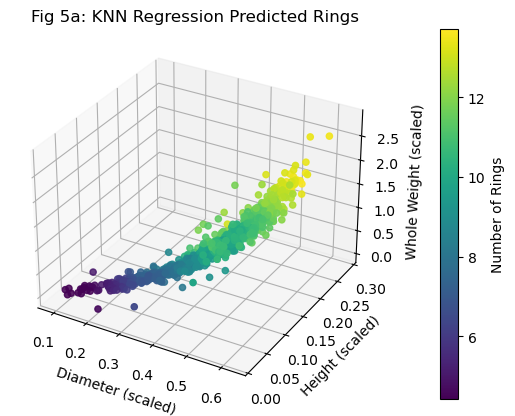

In [73]:
# Creating a 3D plot with color representing the target variable
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_ylim([0, 0.3])

sc = ax.scatter(abalone_predictions["diameter"], abalone_predictions["height"], abalone_predictions["weight_whole"], c=abalone_predictions["predicted_rings"])

ax.set_xlabel("Diameter (scaled)")
ax.set_ylabel("Height (scaled)")
ax.set_zlabel("Whole Weight (scaled)")
ax.set_title("Fig 5a: KNN Regression Predicted Rings") #not sure what to title this

cbar = plt.colorbar(sc, label="Number of Rings")

plt.subplots_adjust(right=2)

plt.show()

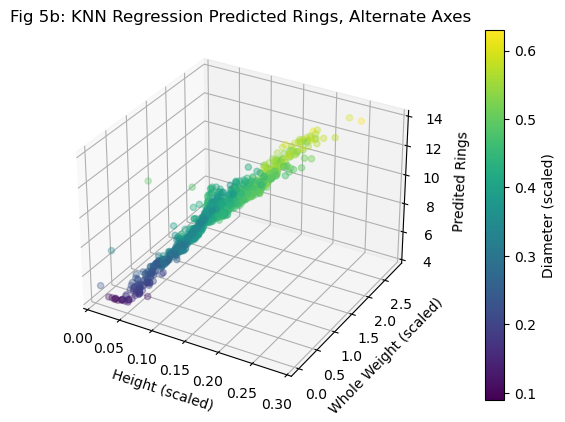

In [74]:
# Alternate axes for a different perspective
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([0, 0.3])

sc = ax.scatter(abalone_predictions["height"], abalone_predictions["weight_whole"], abalone_predictions["predicted_rings"], c=abalone_predictions["diameter"])

ax.set_xlabel("Height (scaled)")
ax.set_ylabel("Whole Weight (scaled)")
ax.set_zlabel("Predited Rings")
ax.set_title("Fig 5b: KNN Regression Predicted Rings, Alternate Axes")

cbar = plt.colorbar(sc, label="Diameter (scaled)")

plt.subplots_adjust(right=2)

plt.show()

In [72]:
rings_v_diameter = alt.Chart(abalone_predictions).mark_point(opacity=0.5).encode(
    x = alt.X("diameter").title("Diameter (scaled)"),
    y = alt.Y("rings").title("Number of Rings")
)

#filtered out an extreme outlier in terms of height (double the next greatest value)
rings_v_height = alt.Chart(abalone_predictions[(abalone_predictions["height"] < 0.3)]).mark_point(opacity=0.5).encode(
    x = alt.X("height").title("Height (scaled)").scale(domain=[0, 0.3]),
    y = alt.Y("rings").title("Number of Rings")
)

rings_v_weight = alt.Chart(abalone_predictions).mark_point(opacity=0.5).encode(
    x = alt.X("weight_whole").title("Whole Weight (scaled)"),
    y = alt.Y("rings").title("Number of Rings")
)

pred_rings_v_diameter = rings_v_diameter + alt.Chart(abalone_predictions, title="Fig 7a: Predicted Rings vs. Diameter").mark_line(
    color="#ff7f0e"
).encode(
    x="diameter",
    y="predicted_rings"
)

pred_rings_v_height = rings_v_height + alt.Chart(abalone_predictions[(abalone_predictions["height"] < 0.3)], title="Fig 7b: Predicted Rings vs. Height").mark_line(
    color="#ff7f0e"
).encode(
    x="height",
    y="predicted_rings"
)

pred_rings_v_weight = rings_v_weight + alt.Chart(abalone_predictions, title="Fig 7c: Predicted Rings vs. Whole Weight").mark_line(
    color="#ff7f0e"
).encode(
    x="weight_whole",
    y="predicted_rings"
)

pred_rings_v_diameter | pred_rings_v_height | pred_rings_v_weight

alt.HConcatChart(...)

## Discussion

### Summary of Findings
After finding the RMSPE of the KNN regression and linear regression implementations, it was found that the KNN regression model had a lower RMPSE value (2.4888979256328763 compared to 2.7885659244182652). This showed that this model is slightly better at predicting the number of rings on an abalone. It was also found that the best n_neighbors value was 82. We used this model to predict for the observations in the test set. We also showed how the model could be used to predict the age of an abalone with a completely new observation. The model predicted that hypothetical abalones with diameters of 0.6mm and 0.4mm, heights of 0.27mm and 0.12mm, and whole weights of 2.0mm and 1.1mm would have predicted ages of around 15.1 years and 12.8 years.

The predictive model successfully established a positive and fairly linear relationship between the number of rings (representing age) in abalones and each of the selected predictors: diameter, height, and whole weight. 2D and 3D Visualizations (figures 5 and 6) provided insights into consistent patterns and alignments, affirming the model's overall performance.

However, challenges were observed in predicting ages above 7 rings, suggesting a potential saturation or weakening of the relationship between weight and rings beyond a certain age threshold. Despite this limitation, the streamlined age prediction model holds practical significance for abalone farmers and consumers.


### Expected Outcomes VS Findings

In the preliminary analysis, a positive correlation between the number of rings and predictors was observed, consistent with the expected linear and positive relationship.

However, there are a couple of potential limitations:

1. Accuracy might decline when predicting above 7 rings due to a weakened relationship between weight and rings. We can actually see how the KNN line becomes flat as we start cross 2.0 grams. As well, the number of rings a given abalone could have is pretty spread out as each of the predictor variables grow in size.

2. The model's accuracy may be impacted by unaccounted environmental parameters, such as weather patterns and location. Future research should concentrate on refining predictive models to incorporate these variables and enhance overall model robustness.

<!-- #### \<Above was the "expected outcomes" Add discussion about how it relates to findings> -->

### Significance and Impact of Findings

<!-- #### \<add more to talk about the findings and impact of that> -->

Creating a model to easily and quickly determine the age of an abalone would greatly help with sorting and pricing abalones. This would not only benefit farmers, but also consumers, who can now purchase based on age (abalone tastes better with age).

Moreover, an efficient method of determining the age of an abalone also helps farmers enhance the sustainability of their fishing practices by choosing size limits and catch quotas to prevent overexploitation and maintain a healthy population.
Overall, the findings provide a valuable foundation for practical applications in the abalone industry.

### Future topics of research and questions:

- How do abalone prices depend on age?

    - What is the optimal age for an abalone to be sold on the market to maximize profits?

        - Investigate the relationship between abalone age and market prices to understand the pricing dynamics.

        - Explore the economic implications by determining the optimal age for selling abalones to maximize profits, considering factors such as market demand and growth patterns.

- Dataset Quality?

    - In our dataset, we identified instances where observations were inaccurately recorded. Specifically, the height was recorded as 0 for two observations, a logically implausible scenario. Despite this anomaly, we opted to retain the data, as the overall pattern of observations did not exhibit any noticeable irregularities. Our assumption is that these instances are likely attributable to data entry errors.

    - Another issue arose concerning the variable `total weight`. In 153 observations, we observed that the weights of predictors such as `shucked_weight`, `viscera_weight`, and `shell_weight` did not align with or were less than the recorded `total weight`. This incongruence suggests a potential error in data recording that requires further investigation and correction.


## References

### Dataset
Nash,Warwick, Sellers,Tracy, Talbot,Simon, Cawthorn,Andrew, and Ford,Wes. (1995). Abalone. UCI Machine Learning Repository. https://doi.org/10.24432/C55C7W.

### Other Sources
Aquaculture Stewardship Council. (2023, June 26). Abalone. ASC International. https://asc-aqua.org/learn-about-seafood-farming/farmed-abalone/ 

Hossain, Md. M., &amp; Chowdhury, M. N. M. (2019, January 3). Econometric ways to estimate the age and price of abalone. Munich Personal RePEc Archive. https://mpra.ub.uni-muenchen.de/91210/ 

Huen, B. (2023, September 21). What exactly is abalone and how do you eat it?. Food Republic. https://www.foodrepublic.com/1294247/what-is-abalone-and-why-do-we-love-it/ 